# Tests for Fast DTW and Threshold in tetrode data

## 2016.01.29

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import medfilt
import math
import gitInformation
from neo.io import NeuralynxIO
import sklearn
from scipy.interpolate import Rbf
import fastdtw
import time

In [8]:
%matplotlib inline

In [2]:
gitInformation.printInformation()

Information about this notebook
Date: 2016-01-29
Python Version: 2.7.10 |Anaconda 2.3.0 (64-bit)| (default, May 28 2015, 16:44:52) [MSC v.1500 64 bit (AMD64)]
Git directory: C:\Users\Dominik\Documents\GitRep\kt-2015-DSPHandsOn\.git
Current git SHA: e6d8cd8a76886c134c66e781ccd5c61afc7f9e75
Remotes: origin, 
Current branch: master
origin remote URL: https://github.com/dowa4213/kt-2015-DSPHandsOn.git


### Load, save and filter all the data

In [3]:
# Session folder with all needed neuralynx files
sessionfolder = 'C:\\Users\\Dominik\\Documents\\GitRep\\kt-2015-DSPHandsOn\\MedianFilter\\Python\\08. Tests'

In [4]:
NIO = NeuralynxIO(sessiondir = sessionfolder, cachedir = sessionfolder)
block = NIO.read_block()
seg = block.segments[0]

In [5]:
analogsignals = {}
# Save all recorded datas in a analogsignals dictionary.
for i in range(len(seg.analogsignalarrays)):
    analogsignals["analogsignal{0}".format(i)] = seg.analogsignalarrays[i]

In [7]:
csc = {}
count = -1
# Extract the magnitude of each data.
for i in analogsignals:
    csc["csc{0}".format(i[-1])] = analogsignals[i].magnitude

In [10]:
# Check if the Signal is already inverted, if not, invert it 
for i in analogsignals:
    temp = analogsignals[i]
    if temp.annotations['InputInverted'] == 'False':
        csc["csc{0}".format(i[-1])] = csc["csc{0}".format(i[-1])] * (-1)

In [11]:
filtered = {}
# Filter each data with a median filter with window length 25(seems to be the best)
for i in csc:
    temp = csc[i]
    filtered["filtered{0}".format(i[-1])] = medfilt(temp, 25)

In [12]:
new_data = {}
for i in filtered:
    temp = filtered[i]
    new_data["new_data{0}".format(i[-1])] = csc["csc{0}".format(i[-1])] - temp

In [13]:
threshold = {}
# Calculate the Threshold
for i in new_data:
    temp = new_data[i]
    threshold["threshold{0}".format(i[-1])] = 5*np.median(abs(temp)/0.6745)

### Plot data and the thresholds

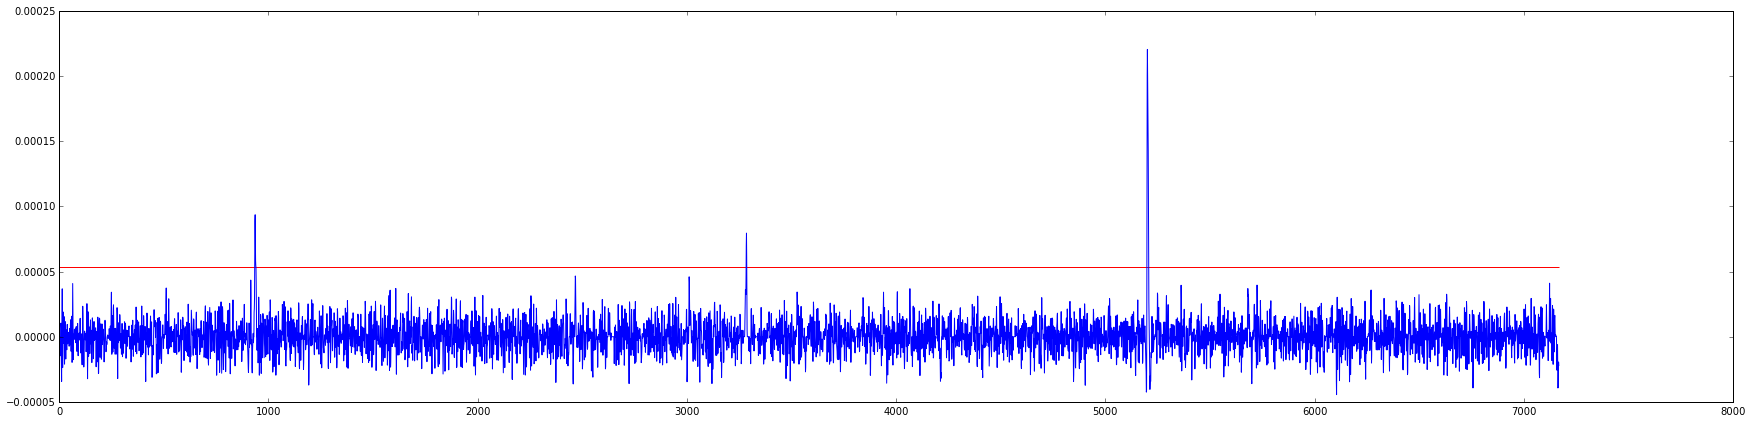

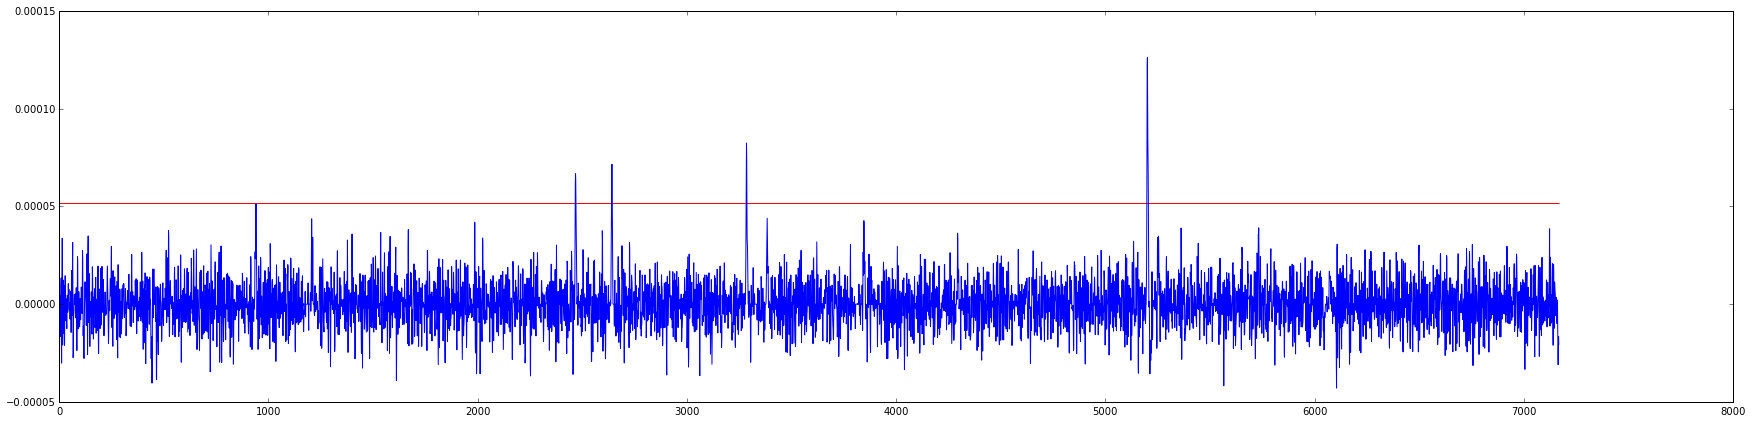

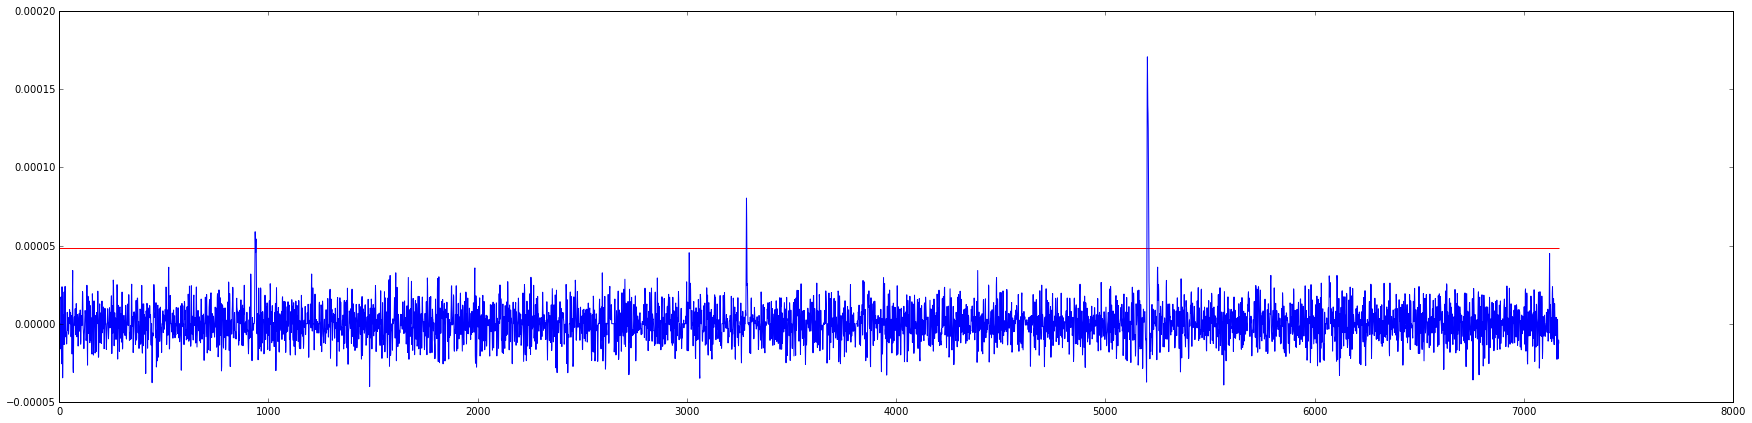

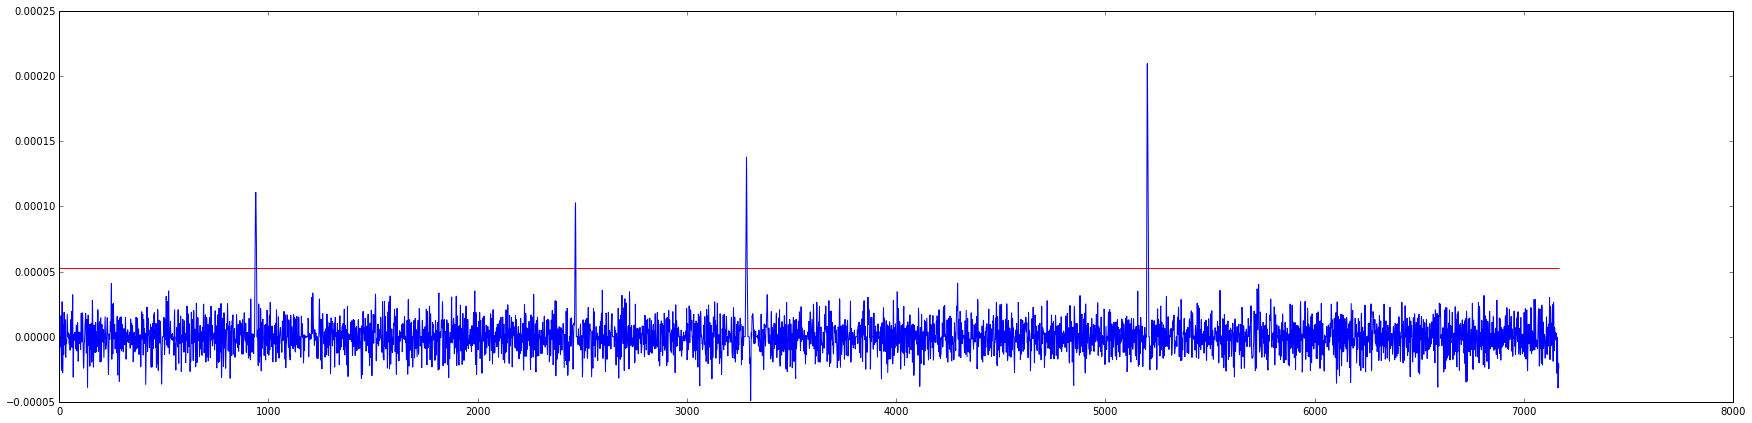

In [24]:
plt.figure(figsize=(30,7))
plt.plot(new_data["new_data0"])
plt.hlines(threshold["threshold0"], 0, len(new_data["new_data0"]), color = 'red')
plt.figure(figsize=(30,7))
plt.plot(new_data["new_data1"])
plt.hlines(threshold["threshold1"], 0, len(new_data["new_data0"]), color = 'red')
plt.figure(figsize=(30,7))
plt.plot(new_data["new_data2"])
plt.hlines(threshold["threshold2"], 0, len(new_data["new_data0"]), color = 'red')
plt.figure(figsize=(30,7))
plt.plot(new_data["new_data3"])
plt.hlines(threshold["threshold3"], 0, len(new_data["new_data0"]), color = 'red')

In [132]:
def shapes(data, threshold):
    count  = -1
    count2 = 0
    timer = 0
    positionlist = []
    # Dictionary with all thresholded shapes
    thresholds = {}
    
    for v in new_data:
        temp = new_data[v]
        
        for element in temp:
            # Increment the counter (counter = position in the array)
            count += 1 
            # Check if the threshold is reached, and check if the window is inside the array
            if element >= threshold["threshold{0}".format(v[-1])] and (count - 10) >= 0 and (count + 14) <= len(temp):
                # Save a window with 24 samples
                tempdata = [w for w in temp[count -10 : count + 14]]
                # Save the position of the window in the original array
                tempsavedcounter = np.linspace(count-10, count + 14, 25)
                # Calculate the maximum value of the window 
                maximum = max(tempdata)
                # Get the position of the maximum value inside the window
                maxposition = [p for p, q in enumerate(tempdata) if q == maximum]
                # Store the position (Note that the position here is the position in the original data)
                position = tempsavedcounter[maxposition[0]]
                tempdata = [w for w in temp[position -10 : position + 14]]
                
                # Search in the other recorded data at the same position for spikes, check if the maximum
                # in any other window is bigger, if True, replace the old shape with the new one
                # We will get always the spike with the maximum amplitude 
                for i in new_data:
                    if i[-1] != v[-1]:
                        tempdata2 = new_data[i]
                        tempdata2 = tempdata2[position -10 : position + 14]
                        if max(tempdata2) > max(tempdata):
                            tempdata = tempdata2
                position = int(position)
                # Check if we didn't find the spike allready
                
                if timer == 0 and all([i not in positionlist for i in range(position - 6, position + 10)]):
                    # set the timer to 16, so 16 samples will be passed
                    timer = 16
                    # increment count2, for the array name
                    count2 += 1
                    # Store the shape in a dictionary
                    thresholds["spike{0}".format(count2)] = tempdata
                    positionlist.append(position)
                    
            elif timer > 0: 
                # Decrement the timer.
                timer -= 1
        count = -1
    return thresholds

In [133]:
shapes = thresHold(new_data, threshold)

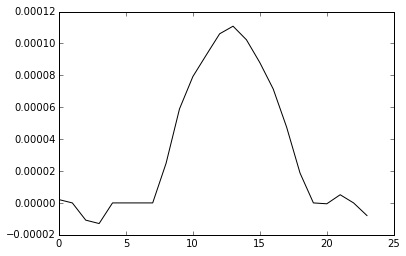

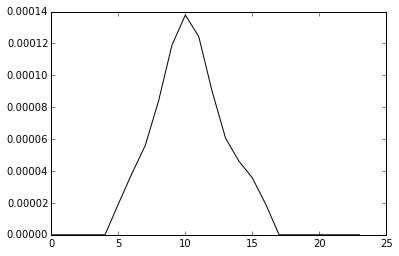

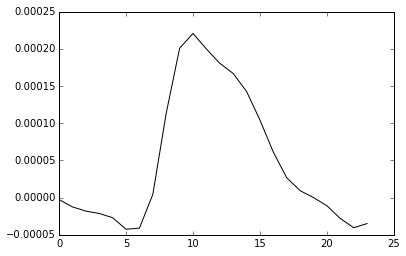

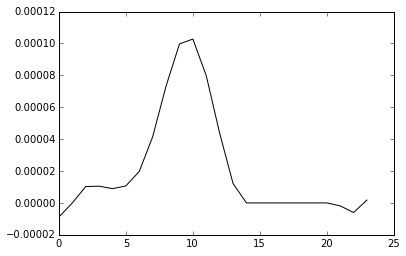

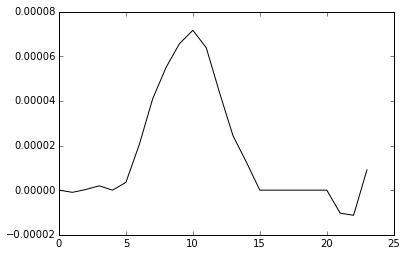

In [131]:
count = 0
for i in shapes:
    count += 1
    plt.figure(count)
    plt.plot(shapes[i], color = "black")

# Result:

The threshold works correctly, we get 5 spikes out of the raw data and the spike with the max amplitude is always saved.